# Space Images Classifier - Using Kaggle dataset

https://www.kaggle.com/datasets/abhikalpsrivastava15/space-images-category?utm_source=chatgpt.com

### Notebook 4 - Training stage 1 (Frozen backbone)

# Import librairies

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
import json

# Add the root folder to Python's module search path
sys.path.append(os.path.abspath(os.path.join(".."))) 
# Import the project configuration
from config import DEVICE, OUTPUT_PATH, BATCH_SIZE, NUM_WORKERS, EPOCHS_STAGE1, LEARNING_RATE_STAGE1
from models import SpaceClassifier
from train_utils import train_epoch, validate
from datasets import SpaceImageDataset, train_transforms, val_test_transforms

import shutil
from pathlib import Path
import cv2
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight

# Load callback/config variables

In [2]:
ROOT_PATH = Path("..")
# Path to load JSON
CONFIG_JSON_PATH = ROOT_PATH / "config_dynamic.json"

try:
    with open(CONFIG_JSON_PATH) as f:
        dynamic_config = json.load(f)
except FileNotFoundError:
    dynamic_config = {}
    
NUM_CLASSES = dynamic_config.get("NUM_CLASSES", 0)
class_names = dynamic_config.get("class_names", [])
split_success = dynamic_config.get("split_success", 5)

# Path to the saved tensor
WEIGHTS_PATH = Path("models") / "class_weights_tensor.pth"

# Load the tensor
class_weights_tensor = torch.load(WEIGHTS_PATH, map_location=DEVICE)

In [3]:
class_weights_tensor

tensor([1.0052, 1.1092, 0.7798, 1.0904, 1.0461, 1.0546], device='mps:0')

# Training stage 1 with frozen backbone

## Create EfficientNet-B0 model

In [4]:
# Create model
model = SpaceClassifier(NUM_CLASSES, pretrained=True)
model = model.to(DEVICE)

print("=" * 80)
print(f"Model created: EfficientNet-B0")
print(f"Device: {DEVICE}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

print("=" * 80)

Model created: EfficientNet-B0
Device: mps
Total parameters: 4,796,290
Trainable parameters: 788,742


In [5]:
print(model.backbone.classifier)

Sequential(
  (0): Dropout(p=0.4, inplace=False)
  (1): Linear(in_features=1280, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=256, out_features=6, bias=True)
)


## Create Dataset

In [6]:
train_dataset = SpaceImageDataset(OUTPUT_PATH / "train", transform=train_transforms)
val_dataset = SpaceImageDataset(OUTPUT_PATH / "validation", transform=val_test_transforms)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Dataset created from ../space_images_split/train
   -> 765 valid images
7 images skipped (see ../space_images_split/train/skipped_images.txt)
Dataset created from ../space_images_split/validation
   -> 161 valid images
2 images skipped (see ../space_images_split/validation/skipped_images.txt)


## Create Data loaders

In [7]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE.type == 'mps' else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE.type == 'mps' else False
)

## Training the model - Phase 1

In [8]:
if split_success:
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE_STAGE1)
    # Automatically reduces the learning rate by 50% if validation loss stops improving for 5 epochs
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    print("=" * 80)
    print(f"Starting Stage 1 Training")
    print("-" * 80)
    print(f"Estimated time on M1: 30-60 minutes\n")
    print("=" * 80)
    
    history_stage1 = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_val_acc = 0.0
    patience_counter = 0
    PATIENCE = 10
    
    for epoch in range(EPOCHS_STAGE1):
        print("=" * 80)
        print(f"Epoch {epoch+1}/{EPOCHS_STAGE1}")
        print("-" * 60)
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
        
        # Validate
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, DEVICE)
        
        # Scheduler step
        scheduler.step(val_loss)
        
        # Save history
        history_stage1['train_loss'].append(train_loss)
        history_stage1['train_acc'].append(train_acc)
        history_stage1['val_loss'].append(val_loss)
        history_stage1['val_acc'].append(val_acc)
        
        print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'models/stage1_best.pth')
            print(f"Best model saved! (Val Acc: {val_acc*100:.2f}%)")
            # Save stage 1 logs to the disk
            torch.save(history_stage1, 'models/history_stage1_del_img.pt')
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping triggered (patience={PATIENCE})")
            break

    print("\nStage 1 training complete!")

else:
    history_stage1 = None

print("=" * 80)

Starting Stage 1 Training
--------------------------------------------------------------------------------
Estimated time on M1: 30-60 minutes

Epoch 1/25
------------------------------------------------------------


Training:  46%|████▌     | 11/24 [00:05<00:03,  3.67it/s, loss=1.5551, acc=29.17%]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:23<00:00,  3.97s/it, loss=2.8037, acc=46.58%]



Train Loss: 1.5589 | Train Acc: 40.78%
Val Loss:   1.2414 | Val Acc:   46.58%
Best model saved! (Val Acc: 46.58%)
Epoch 2/25
------------------------------------------------------------


Training:  46%|████▌     | 11/24 [00:04<00:03,  3.34it/s, loss=1.1391, acc=57.55%]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:23<00:00,  3.87s/it, loss=2.8446, acc=52.17%]



Train Loss: 1.1498 | Train Acc: 55.56%
Val Loss:   1.1593 | Val Acc:   52.17%
Best model saved! (Val Acc: 52.17%)
Epoch 3/25
------------------------------------------------------------


Training:  38%|███▊      | 9/24 [00:04<00:04,  3.56it/s, loss=0.8638, acc=60.07%]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:23<00:00,  3.87s/it, loss=2.3233, acc=56.52%]



Train Loss: 1.0751 | Train Acc: 59.08%
Val Loss:   1.1082 | Val Acc:   56.52%
Best model saved! (Val Acc: 56.52%)
Epoch 4/25
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:23<00:00,  3.99s/it, loss=2.5571, acc=59.63%]



Train Loss: 1.0461 | Train Acc: 59.08%
Val Loss:   1.0993 | Val Acc:   59.63%
Best model saved! (Val Acc: 59.63%)
Epoch 5/25
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:23<00:00,  3.91s/it, loss=2.6095, acc=54.66%]



Train Loss: 0.9128 | Train Acc: 65.62%
Val Loss:   1.1217 | Val Acc:   54.66%
Epoch 6/25
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:23<00:00,  3.90s/it, loss=3.0375, acc=56.52%]



Train Loss: 0.9030 | Train Acc: 67.45%
Val Loss:   1.0757 | Val Acc:   56.52%
Epoch 7/25
------------------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:23<00:00,  3.91s/it, loss=3.9518, acc=54.66%]



Train Loss: 0.8627 | Train Acc: 67.19%
Val Loss:   1.1207 | Val Acc:   54.66%
Epoch 8/25
------------------------------------------------------------


Training:  38%|███▊      | 9/24 [00:04<00:05,  2.76it/s, loss=0.8158, acc=63.89%]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:23<00:00,  3.91s/it, loss=3.6251, acc=57.76%]



Train Loss: 0.8712 | Train Acc: 67.45%
Val Loss:   1.0822 | Val Acc:   57.76%
Epoch 9/25
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:23<00:00,  3.90s/it, loss=3.1687, acc=57.76%]



Train Loss: 0.8405 | Train Acc: 66.67%
Val Loss:   1.0741 | Val Acc:   57.76%
Epoch 10/25
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:23<00:00,  3.92s/it, loss=3.0414, acc=62.11%]



Train Loss: 0.8443 | Train Acc: 66.54%
Val Loss:   1.0855 | Val Acc:   62.11%
Best model saved! (Val Acc: 62.11%)
Epoch 11/25
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:23<00:00,  3.93s/it, loss=3.0709, acc=57.76%]



Train Loss: 0.8060 | Train Acc: 70.33%
Val Loss:   1.1047 | Val Acc:   57.76%
Epoch 12/25
------------------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:23<00:00,  4.00s/it, loss=2.2528, acc=60.25%]



Train Loss: 0.7495 | Train Acc: 71.63%
Val Loss:   1.0869 | Val Acc:   60.25%
Epoch 13/25
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:23<00:00,  3.91s/it, loss=3.3541, acc=58.39%]



Train Loss: 0.8058 | Train Acc: 69.80%
Val Loss:   1.1074 | Val Acc:   58.39%
Epoch 14/25
------------------------------------------------------------


Training:  42%|████▏     | 10/24 [00:04<00:03,  3.76it/s, loss=1.0527, acc=69.03%]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:23<00:00,  3.88s/it, loss=2.5143, acc=57.14%]



Train Loss: 0.8046 | Train Acc: 70.07%
Val Loss:   1.1273 | Val Acc:   57.14%
Epoch 15/25
------------------------------------------------------------


Training:  50%|█████     | 12/24 [00:04<00:03,  3.81it/s, loss=0.7332, acc=68.99%]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:23<00:00,  3.91s/it, loss=3.4827, acc=63.35%]



Train Loss: 0.7696 | Train Acc: 71.37%
Val Loss:   1.0582 | Val Acc:   63.35%
Best model saved! (Val Acc: 63.35%)
Epoch 16/25
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:23<00:00,  3.89s/it, loss=3.1909, acc=62.11%]



Train Loss: 0.7100 | Train Acc: 74.25%
Val Loss:   1.1401 | Val Acc:   62.11%
Epoch 17/25
------------------------------------------------------------


Training:  46%|████▌     | 11/24 [00:05<00:03,  3.70it/s, loss=0.7890, acc=71.35%]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:23<00:00,  3.89s/it, loss=2.8808, acc=58.39%]



Train Loss: 0.7411 | Train Acc: 72.03%
Val Loss:   1.1200 | Val Acc:   58.39%
Epoch 18/25
------------------------------------------------------------


Training:  67%|██████▋   | 16/24 [00:06<00:01,  4.69it/s, loss=0.7931, acc=72.85%]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:23<00:00,  3.89s/it, loss=3.3419, acc=61.49%]



Train Loss: 0.7013 | Train Acc: 72.68%
Val Loss:   1.0679 | Val Acc:   61.49%
Epoch 19/25
------------------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:23<00:00,  3.88s/it, loss=4.0128, acc=59.01%]



Train Loss: 0.7205 | Train Acc: 71.37%
Val Loss:   1.0628 | Val Acc:   59.01%
Epoch 20/25
------------------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Training:  12%|█▎        | 3/24 [00:03<00:17,  1.22it/s, loss=0.6495, acc=77.34%]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:24<00:00,  4.03s/it, loss=3.9653, acc=54.66%]



Train Loss: 0.6598 | Train Acc: 73.99%
Val Loss:   1.1535 | Val Acc:   54.66%
Epoch 21/25
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:23<00:00,  3.96s/it, loss=2.8181, acc=59.01%]



Train Loss: 0.6955 | Train Acc: 74.12%
Val Loss:   1.1024 | Val Acc:   59.01%
Epoch 22/25
------------------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Training:  79%|███████▉  | 19/24 [00:07<00:01,  4.49it/s, loss=0.3946, acc=75.00%]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:23<00:00,  3.94s/it, loss=2.5981, acc=56.52%]



Train Loss: 0.6269 | Train Acc: 75.16%
Val Loss:   1.1059 | Val Acc:   56.52%
Epoch 23/25
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:23<00:00,  3.88s/it, loss=2.9400, acc=57.14%]



Train Loss: 0.6055 | Train Acc: 77.25%
Val Loss:   1.1251 | Val Acc:   57.14%
Epoch 24/25
------------------------------------------------------------


Validation: 100%|██████████| 6/6 [00:23<00:00,  3.93s/it, loss=2.9062, acc=57.14%]



Train Loss: 0.6103 | Train Acc: 78.17%
Val Loss:   1.1318 | Val Acc:   57.14%
Epoch 25/25
------------------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Validation: 100%|██████████| 6/6 [00:23<00:00,  3.98s/it, loss=2.8722, acc=56.52%]


Train Loss: 0.6048 | Train Acc: 76.47%
Val Loss:   1.1419 | Val Acc:   56.52%

Early stopping triggered (patience=10)

Stage 1 training complete!


# Comparison between skipping images or deleting images methods

In [9]:
import torch
import matplotlib.pyplot as plt

# Load both histories
history_skp = torch.load("models/history_stage1_skp_img.pt")
history_del = torch.load("models/history_stage1_del_img.pt")

# Ensure they have the same keys
print("Keys in history:", history_skp.keys())

# Quick numeric comparison
for key in history_skp.keys():
    skp_vals = history_skp[key]
    del_vals = history_del[key]
    
    print(f"\n=== {key.upper()} ===")
    print(f"Last (skp): {skp_vals[-1]:.4f}")
    print(f"Last (del): {del_vals[-1]:.4f}")
    print(f"Best (skp): {max(skp_vals) if 'acc' in key else min(skp_vals):.4f}")
    print(f"Best (del): {max(del_vals) if 'acc' in key else min(del_vals):.4f}")


Keys in history: dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc'])

=== TRAIN_LOSS ===
Last (skp): 0.8429
Last (del): 0.7696
Best (skp): 0.8429
Best (del): 0.7495

=== TRAIN_ACC ===
Last (skp): 0.6839
Last (del): 0.7137
Best (skp): 0.6839
Best (del): 0.7163

=== VAL_LOSS ===
Last (skp): 1.0875
Last (del): 1.0582
Best (skp): 1.0689
Best (del): 1.0582

=== VAL_ACC ===
Last (skp): 0.6074
Last (del): 0.6335
Best (skp): 0.6074
Best (del): 0.6335


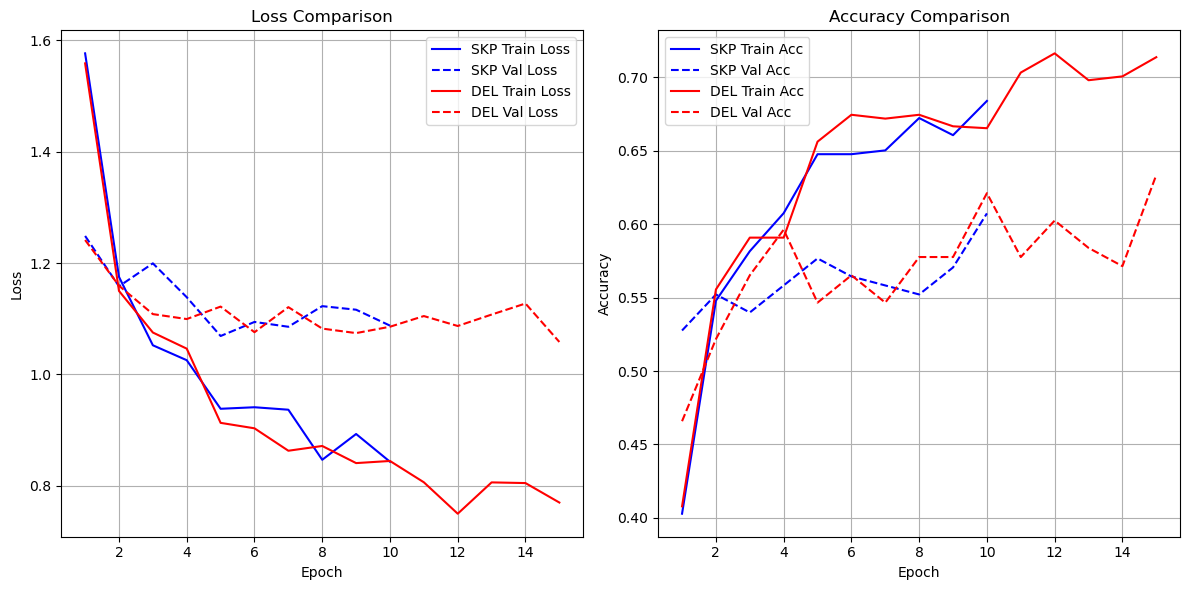

In [10]:
epochs_skp = range(1, len(history_skp['train_loss']) + 1)
epochs_del = range(1, len(history_del['train_loss']) + 1)

plt.figure(figsize=(12, 6))

# --- Training Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs_skp, history_skp['train_loss'], 'b-', label='SKP Train Loss')
plt.plot(epochs_skp, history_skp['val_loss'], 'b--', label='SKP Val Loss')
plt.plot(epochs_del, history_del['train_loss'], 'r-', label='DEL Train Loss')
plt.plot(epochs_del, history_del['val_loss'], 'r--', label='DEL Val Loss')
plt.title("Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# --- Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(epochs_skp, history_skp['train_acc'], 'b-', label='SKP Train Acc')
plt.plot(epochs_skp, history_skp['val_acc'], 'b--', label='SKP Val Acc')
plt.plot(epochs_del, history_del['train_acc'], 'r-', label='DEL Train Acc')
plt.plot(epochs_del, history_del['val_acc'], 'r--', label='DEL Val Acc')
plt.title("Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


- Left plot : DEL method has a more stable val loss curve, slightly lower overall > good sign of better generalization

- For training accuracy, both methods reach ~70–73%, with DEL slightly ahead at some points and same for the validation accuracy, DEL consistently stays above SKP for most epochs. Moreover, SKP method seems to plateau around 55–60%, while DEL reaches ~61–63%. Overall the DEL method tends to be more stable (right plot) suggesting better generalization

- DEL seems to be a better method with :
    1. Slightly lower train/val loss.
    2. Higher and more stable validation accuracy.
    3. Less overfitting behavior.

# End of notebook 4 - Training stage 1